# Rede neural com camadas escondidas - Classificação do Iris dataset

O objetivo desse experimento é ilustrar o uso de rede neural que tenha mais de uma camada. Isso é conseguido com a inserção de uma ativação não linear entre as camadas.

Datasets utilizados:
    - Iris - 3 classes
    - Sintéticos:
        - meia luas
        - círculos circunscritos
        - blobs

![alt text](https://raw.githubusercontent.com/vcasadei/images/master/Net2RegressaoSoftmaxArgmaxRede.png)

## Importando as bibliotecas

In [35]:
%matplotlib inline
from sklearn import datasets
from IPython import display
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import torch
import torch.nn as nn

## Leitura, normalização e visualização dos dados

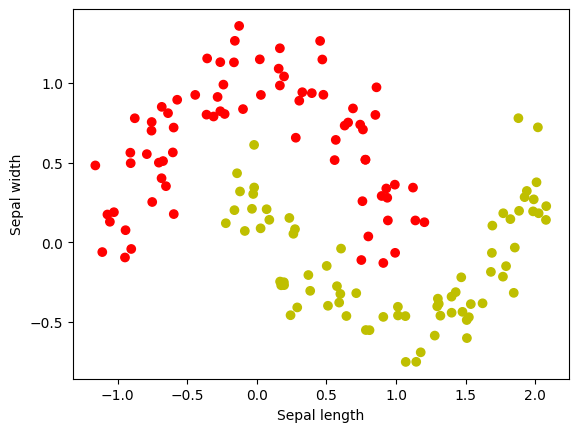

In [36]:
n_samples = 150
options = ['iris', 'moon', 'circles', 'blobs']
option = options[1]
if option == 'iris':
    iris = datasets.load_iris()
    X = iris.data[:,:2]  # comprimento das sépalas e pétalas, indices 0 e 2
    Xc = X - X.min(axis=0)
    Xc /= Xc.max(axis=0)
    Y = iris.target
elif option == 'moon':
    Xc,Y = datasets.make_moons(n_samples=n_samples, noise=.15)
elif option == 'circles':
    Xc,Y = datasets.make_circles(n_samples=n_samples, factor=.5, noise=.1)
elif option == 'blobs':
    Xc,Y = datasets.make_blobs(n_samples=n_samples,centers=3,cluster_std=1.2)

colors = np.array(['r','y','b'])
plt.scatter(Xc[:, 0], Xc[:, 1], c=colors[Y])
plt.xlabel('Sepal length')
plt.ylabel('Sepal width')
plt.show()

### Prepara os dados para o PyTorch

In [37]:
X_tensor = torch.FloatTensor(Xc)
Y_tensor = torch.LongTensor(Y)

## Construindo o modelo da rede

In [38]:
class Modelo(nn.Module):
    def __init__(self):
        super(Modelo, self).__init__()
        self.dense = nn.Sequential(
            nn.Linear(2, 5),
            nn.Sigmoid(),
            nn.Linear(5, 5),
            nn.Sigmoid(),
            nn.Linear(5,3),
        )

    def forward(self, x):
        x = self.dense(x)

        return x

model = Modelo()
print(model)

Modelo(
  (dense): Sequential(
    (0): Linear(in_features=2, out_features=5, bias=True)
    (1): Linear(in_features=5, out_features=5, bias=True)
    (2): Linear(in_features=5, out_features=3, bias=True)
  )
)


## _predict_ utilizada para predição de classes e na visualização

In [39]:
def predict(model, inputs):
    outputs = model(inputs)
    _, predicts = torch.max(outputs, 1)

    return predicts.data.numpy()

## Classe para visualização dinâmica

In [40]:
class BoundaryPlotter():
    def __init__(self, model, X, Y, n_epoch, filepath=None, h = .01):
        self.model = model
        self.X = X
        self.Y = Y
        self.n_epoch = n_epoch
        self.filepath = filepath
        x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
        y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
        self.xx, self.yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
        self.loss_hist = []
        self.val_loss_hist = []
        self.X_grid = np.c_[self.xx.ravel(), self.yy.ravel()]

        #Gráficos a serem mostrados pelo callback
        self.fig = plt.figure(figsize=(8, 4), dpi=100)
        self.ax1 = self.fig.add_subplot(1, 2, 1)
        self.ax1.set_xlim(0, nb_epoch)
        self.ax1.set_xlabel('Epoca')#,fontsize=28)
        self.ax1.set_ylabel('Perda')#,fontsize=28)
        self.ax1.plot([],[],'b',linewidth = 2.0,label = "Treino")
        self.ax1.grid(True)

        self.ax2 = self.fig.add_subplot(1, 2, 2)
        self.ax2.set_xlim(Xc[:,0].min(), Xc[:,0].max())
        self.ax2.set_ylim(Xc[:,1].min(), Xc[:,1].max())
        self.ax2.set_xlabel('Comprimento da Sepala')#,fontsize=28)
        self.ax2.set_ylabel('Largura da Sepala')#,fontsize=28)

    def on_train_begin(self, logs={}):
        display.display(self.fig)
        display.clear_output(wait=True)

    def on_epoch_end(self, epoch, logs={}):
        if 'loss' in logs.keys():
            self.loss_hist.append(logs['loss'])

            if epoch%250==0:
                self.ax1.plot(np.arange(epoch+1), self.loss_hist, 'b', linewidth = 2.0)

                Z = predict(self.model, torch.from_numpy(self.X_grid).type(torch.FloatTensor))
#                 Z = torch.max(self.model(Variable(torch.FloatTensor(self.X_grid))).data, dim=1)[1].numpy()
                Z = Z.reshape(self.xx.shape)

                self.ax2.pcolormesh(self.xx, self.yy, Z, cmap=plt.cm.Paired)
                colors = np.array(['r','y','b'])
                self.ax2.scatter(self.X[:, 0], self.X[:, 1], s=40, c=colors[self.Y], edgecolors='k', cmap=plt.cm.Paired)

                display.display(self.fig)
                display.clear_output(wait=True)

## Treinamento

In [41]:
lr = 0.15

optimizer = torch.optim.SGD(model.parameters(), lr=lr)

criterion = nn.CrossEntropyLoss()

### Laço principal de treinamento

Final loss: tensor(0.3017)


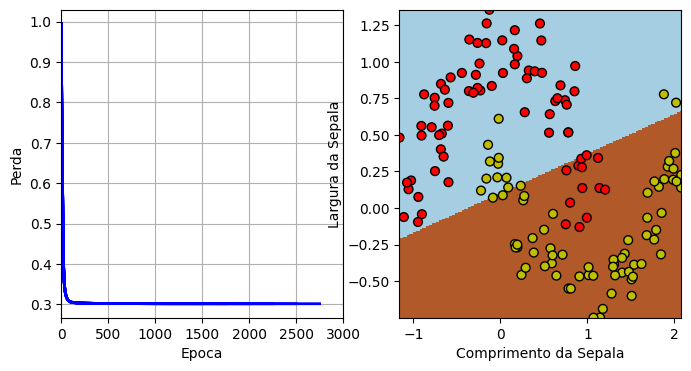

In [42]:
batch_size = 150
nb_epoch = 3000

#Definindo o plotter
boundary_plot = BoundaryPlotter(model, Xc, Y, nb_epoch)

boundary_plot.on_train_begin()
losses = []
for i in range(nb_epoch):
    # predict da rede
    output = model(X_tensor)

    loss = criterion(output, Y_tensor)

    # zero, backpropagation gradient, atualiza param gradiente descendente
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    losses.append(loss.data)

    boundary_plot.on_epoch_end(i, {'loss': loss.data})

print('Final loss:', loss.data)

## Avaliação

### Imprimindo pesos finais

In [43]:
for name, w in model.state_dict().items():
    print('{:16}\t{}'.format(name, w.size()))
    print(w, "\n\n")

dense.0.weight  	torch.Size([5, 2])
tensor([[-0.0490, -0.4427],
        [ 0.0012, -0.9598],
        [-0.3070,  0.7249],
        [ 0.2014,  0.3935],
        [ 0.3663, -0.9524]]) 


dense.0.bias    	torch.Size([5])
tensor([-0.8394, -0.5607, -0.7660,  1.0759,  0.1656]) 


dense.1.weight  	torch.Size([5, 5])
tensor([[-0.3716, -0.5119,  0.3567, -0.1204, -0.9290],
        [ 0.6563,  0.5461, -0.2965, -0.6014,  0.0339],
        [ 0.5427, -0.0066,  0.8433, -0.7490, -0.3817],
        [-0.2469, -0.3500, -0.1465, -0.1746, -0.0368],
        [ 0.0214, -0.2215, -0.0570, -0.3621, -0.3347]]) 


dense.1.bias    	torch.Size([5])
tensor([ 0.2415, -0.4169, -0.8552,  0.5724,  0.2305]) 


dense.2.weight  	torch.Size([3, 5])
tensor([[ 0.8940, -0.9925, -0.2494,  0.1317,  0.3149],
        [-0.7251, -0.0565, -1.0616,  0.1005, -0.0761],
        [ 0.0100,  0.4713,  1.0069, -0.5521,  0.2543]]) 


dense.2.bias    	torch.Size([3])
tensor([ 0.0715,  0.2848, -0.9274]) 




### Avaliação do classificador

In [44]:
Y_hat = predict(model, X_tensor)
accuracy = (Y_hat == Y).mean()
print()
print('Training Accuracy: ', accuracy)


Training Accuracy:  0.8333333333333334


### Matriz de confusão

In [45]:
import pandas as pd
pd.crosstab(Y_hat, Y)

col_0,0,1
row_0,,
0,62,12
1,13,63


## Atividades

### Experimentos:

1. Faça alterações na rede, alterando o número de neurônios, de camadas. Escreva suas conclusões.
> Verifica-se que, com redes mais simples (com menor número de neurônios e camadas), a eficiência na classificação fica reduzida, de forma que as fronteiras de separação têm menor chance de dividir os dados corretamente, o que pode se confirmar na acurácia do modelo. <br>

2. No lugar da ReLU, coloque Sigmoid e observe a diferença. O que aconteceu? Descreva.
> Com treinamento mais lento, a função sigmoid não foi capaz de separar dados que se dispoem em curvas, como no caso do dataset "moon" e "circles". A aplicação dela é mais indicada na camada de saída para classificação binária.

3. O que ocorre quando não se utiliza ativação não linear entre camadas?
> A retirada das funções de ativação mostra que não é possível uma rede neural resolver problemas não-lineares sem a existência destas funções.

## Principais aprendizados

As experimentações com uma rede de múltiplas camadas e, naturalmente, funções de ativação entre elas ajudou a demonstrar o conceito de que redes neurais com mais camadas e neurônios são mais capazes de resolver problemas mais complexos e a existência das referidas funções é imprescindível na solução de problemas não-lineares.

Sem as funções de ativação as redes não conseguem criar fronteiras de separação curvas em aplicações de classificação.<br>
Por sua vez, redes com menos neurônios criam separações menos bem definidas do que as de maior complexidade.

Por fim, é importante destacar que a dificuldade da função Sigmoid em lidar com dados dispostos em formatos curvos é um dentre outros motivos que faz com que a função ReLU seja mais comumente empregada em seu lugar.